In [1]:
# This cell defines the functions we use to generate the data in our scenario

import numpy as np
import pandas as pd
import scipy.stats
import sklearn
import xgboost


class FixableDataFrame(pd.DataFrame):
    """Helper class for manipulating generative models."""

    def __init__(self, *args, fixed={}, **kwargs):
        self.__dict__["__fixed_var_dictionary"] = fixed
        super().__init__(*args, **kwargs)

    def __setitem__(self, key, value):
        out = super().__setitem__(key, value)
        if isinstance(key, str) and key in self.__dict__["__fixed_var_dictionary"]:
            out = super().__setitem__(key, self.__dict__["__fixed_var_dictionary"][key])
        return out


# generate the data
def generator(n, fixed={}, seed=0):
    """The generative model for our subscriber retention example."""
    if seed is not None:
        np.random.seed(seed)
    X = FixableDataFrame(fixed=fixed)

    # the number of sales calls made to this customer
    X["Sales calls"] = np.random.uniform(0, 4, size=(n,)).round()

    # the number of sales calls made to this customer
    X["Interactions"] = X["Sales calls"] + np.random.poisson(0.2, size=(n,))

    # the health of the regional economy this customer is a part of
    X["Economy"] = np.random.uniform(0, 1, size=(n,))

    # the time since the last product upgrade when this customer came up for renewal
    X["Last upgrade"] = np.random.uniform(0, 20, size=(n,))

    # how much the user perceives that they need the product
    X["Product need"] = X["Sales calls"] * 0.1 + np.random.normal(0, 1, size=(n,))

    # the fractional discount offered to this customer upon renewal
    X["Discount"] = (
        (1 - scipy.special.expit(X["Product need"])) * 0.5
        + 0.5 * np.random.uniform(0, 1, size=(n,))
    ) / 2

    # What percent of the days in the last period was the user actively using the product
    X["Monthly usage"] = scipy.special.expit(
        X["Product need"] * 0.3 + np.random.normal(0, 1, size=(n,))
    )

    # how much ad money we spent per user targeted at this user (or a group this user is in)
    X["Ad spend"] = (
        X["Monthly usage"] * np.random.uniform(0.99, 0.9, size=(n,))
        + (X["Last upgrade"] < 1)
        + (X["Last upgrade"] < 2)
    )

    # how many bugs did this user encounter in the since their last renewal
    X["Bugs faced"] = np.array([np.random.poisson(v * 2) for v in X["Monthly usage"]])

    # how many bugs did the user report?
    X["Bugs reported"] = (
        X["Bugs faced"] * scipy.special.expit(X["Product need"])
    ).round()

    # did the user renew?
    X["Did renew"] = scipy.special.expit(
        7
        * (
            0.18 * X["Product need"]
            + 0.08 * X["Monthly usage"]
            + 0.1 * X["Economy"]
            + 0.05 * X["Discount"]
            + 0.05 * np.random.normal(0, 1, size=(n,))
            + 0.05 * (1 - X["Bugs faced"] / 20)
            + 0.005 * X["Sales calls"]
            + 0.015 * X["Interactions"]
            + 0.1 / (X["Last upgrade"] / 4 + 0.25)
            + X["Ad spend"] * 0.0
            - 0.45
        )
    )

    # in real life we would make a random draw to get either 0 or 1 for if the
    # customer did or did not renew. but here we leave the label as the probability
    # so that we can get less noise in our plots. Uncomment this line to get
    # noiser causal effect lines but the same basic results
    X["Did renew"] = scipy.stats.bernoulli.rvs(X["Did renew"])

    return X


def user_retention_dataset():
    """The observed data for model training."""
    n = 10000
    X_full = generator(n)
    y = X_full["Did renew"]
    X = X_full.drop(["Did renew", "Product need", "Bugs faced"], axis=1)
    return X, y


def fit_xgboost(X, y):
    """Train an XGBoost model with early stopping."""
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)
    model = xgboost.train(
        {"eta": 0.001, "subsample": 0.5, "max_depth": 2, "objective": "reg:logistic"},
        dtrain,
        num_boost_round=200000,
        evals=((dtest, "test"),),
        early_stopping_rounds=20,
        verbose_eval=False,
    )
    return model

In [2]:
X, y = user_retention_dataset()
model = fit_xgboost(X, y)

In [3]:
%pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.5 MB/s eta 0:00:00


[17:08:32] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[17:08:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


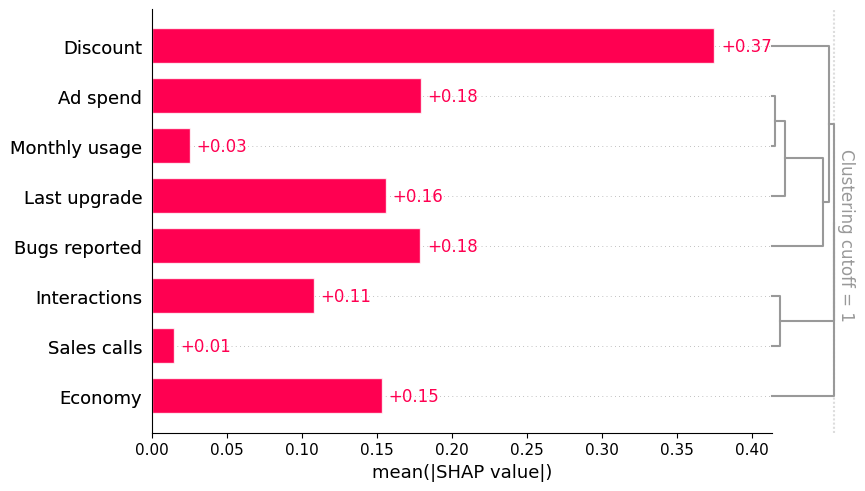

In [4]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

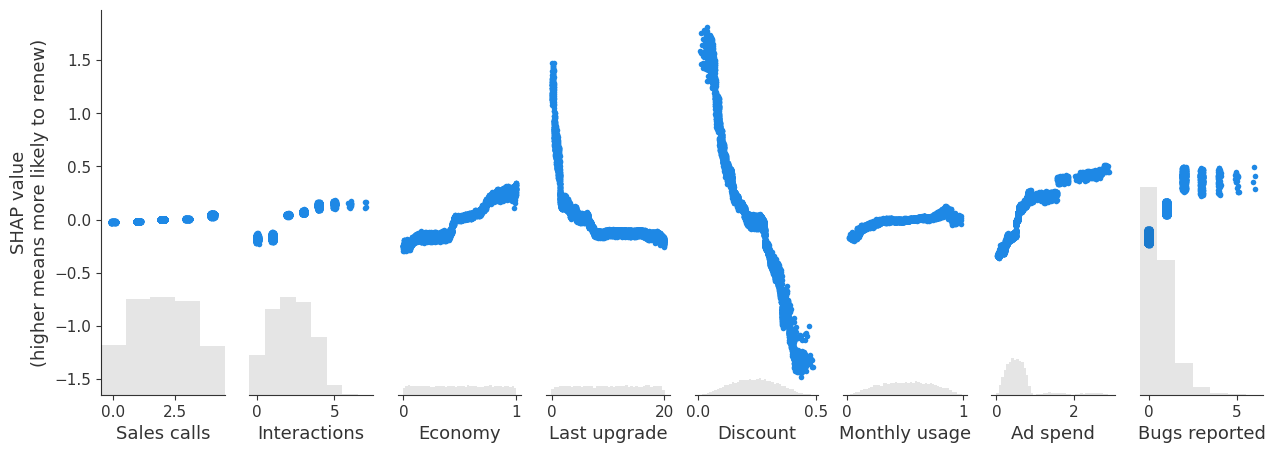

In [5]:
shap.plots.scatter(
    shap_values, ylabel="SHAP value\n(higher means more likely to renew)"
)

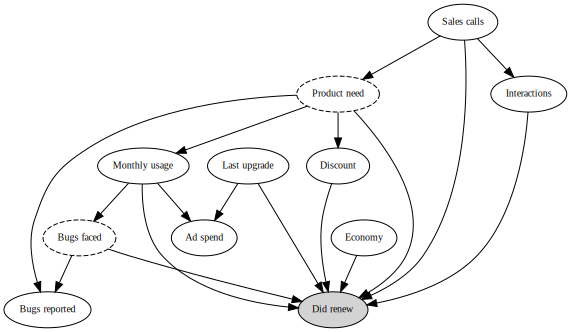

In [6]:
import graphviz

names = [
    "Bugs reported",
    "Monthly usage",
    "Sales calls",
    "Economy",
    "Discount",
    "Last upgrade",
    "Ad spend",
    "Interactions",
]
g = graphviz.Digraph()
for name in names:
    g.node(name, fontsize="10")
g.node("Product need", style="dashed", fontsize="10")
g.node("Bugs faced", style="dashed", fontsize="10")
g.node("Did renew", style="filled", fontsize="10")

g.edge("Product need", "Did renew")
g.edge("Product need", "Discount")
g.edge("Product need", "Bugs reported")
g.edge("Product need", "Monthly usage")
g.edge("Discount", "Did renew")
g.edge("Monthly usage", "Bugs faced")
g.edge("Monthly usage", "Did renew")
g.edge("Monthly usage", "Ad spend")
g.edge("Economy", "Did renew")
g.edge("Sales calls", "Did renew")
g.edge("Sales calls", "Product need")
g.edge("Sales calls", "Interactions")
g.edge("Interactions", "Did renew")
g.edge("Bugs faced", "Did renew")
g.edge("Bugs faced", "Bugs reported")
g.edge("Last upgrade", "Did renew")
g.edge("Last upgrade", "Ad spend")
g

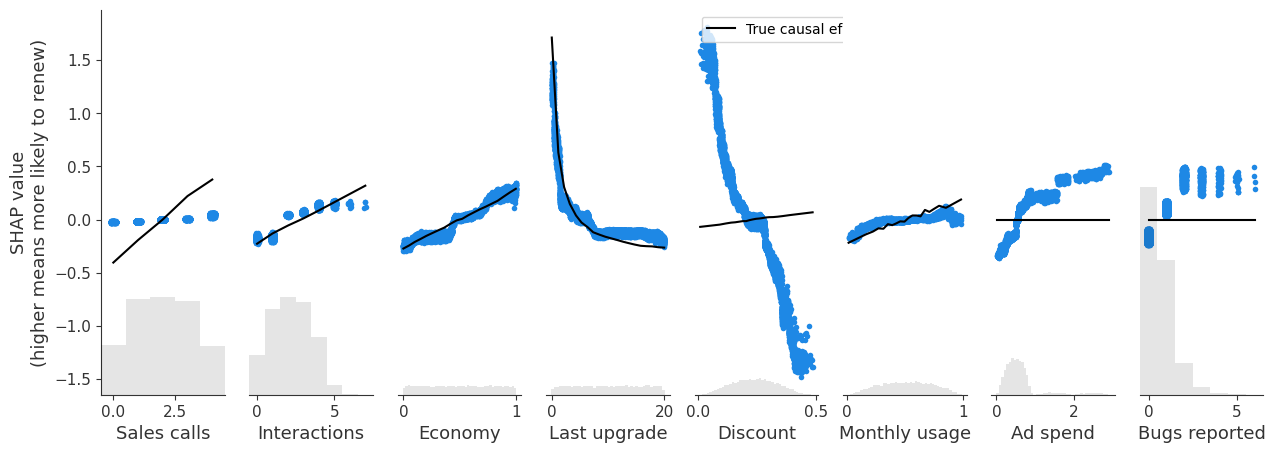

In [7]:
def marginal_effects(
    generative_model, num_samples=100, columns=None, max_points=20, logit=True, seed=0
):
    """Helper function to compute the true marginal causal effects."""
    X = generative_model(num_samples)
    if columns is None:
        columns = X.columns
    ys = [[] for _ in columns]
    xs = [X[c].values for c in columns]
    xs = np.sort(xs, axis=1)
    xs = [xs[i] for i in range(len(xs))]
    for i, c in enumerate(columns):
        xs[i] = np.unique(
            [
                np.nanpercentile(xs[i], v, method="nearest")
                for v in np.linspace(0, 100, max_points)
            ]
        )
        for x in xs[i]:
            Xnew = generative_model(num_samples, fixed={c: x}, seed=seed)
            val = Xnew["Did renew"].mean()
            if logit:
                val = scipy.special.logit(val)
            ys[i].append(val)
        ys[i] = np.array(ys[i])
    ys = [ys[i] - ys[i].mean() for i in range(len(ys))]
    return list(zip(xs, ys))


shap.plots.scatter(
    shap_values,
    ylabel="SHAP value\n(higher means more likely to renew)",
    overlay={"True causal effects": marginal_effects(generator, 10000, X.columns)},
)

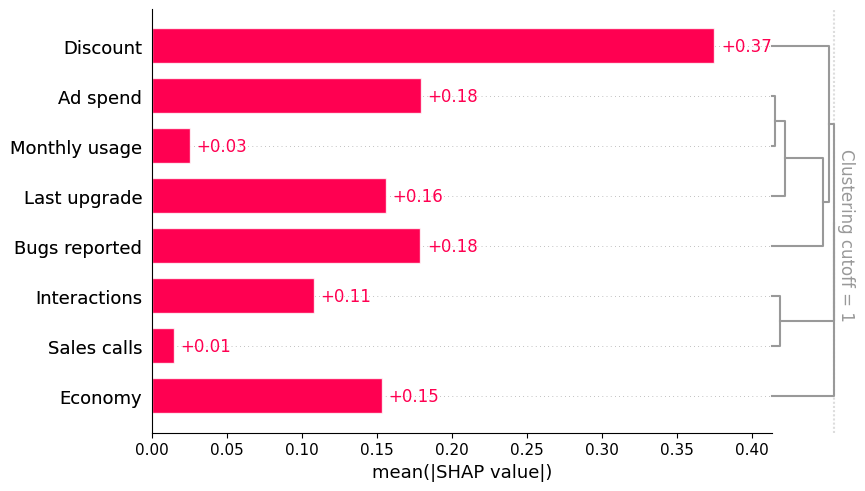

In [8]:
# Economy is independent of other measured features.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

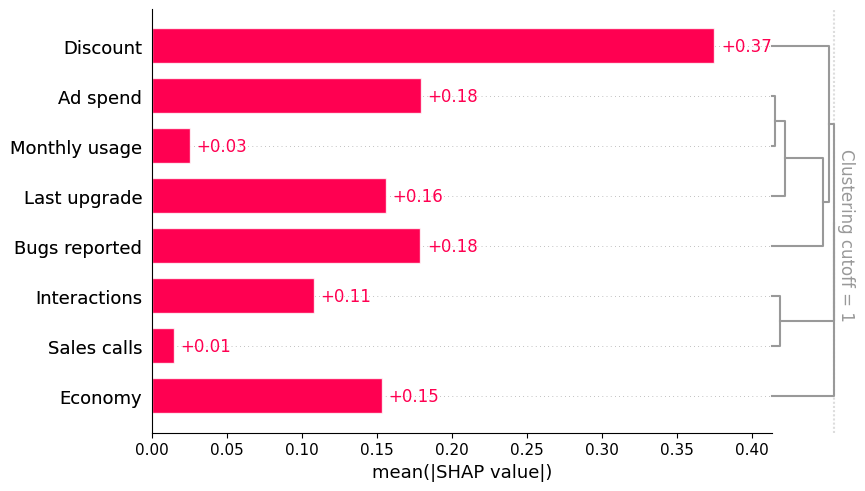

In [9]:
# Ad spend is very redundant with Monthly usage and Last upgrade.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

In [11]:
%pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.43.0
    Uninstalling shap-0.43.0:
      Successfully uninstalled shap-0.43.0


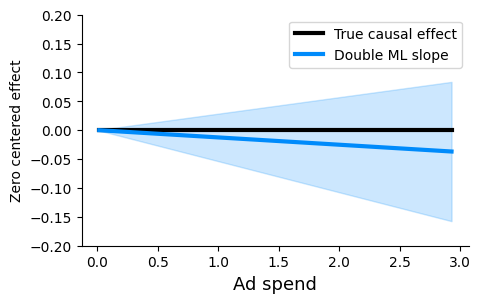

In [12]:
import matplotlib.pyplot as plt
from econml.dml import LinearDML
from sklearn.base import BaseEstimator, clone


class RegressionWrapper(BaseEstimator):
    """Turns a classifier into a 'regressor'.

    We use the regression formulation of double ML, so we need to approximate the classifer
    as a regression model. This treats the probabilities as just quantitative value targets
    for least squares regression, but it turns out to be a reasonable approximation.
    """

    def __init__(self, clf):
        self.clf = clf

    def fit(self, X, y, **kwargs):
        self.clf_ = clone(self.clf)
        self.clf_.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.clf_.predict_proba(X)[:, 1]


# Run Double ML, controlling for all the other features
def double_ml(y, causal_feature, control_features):
    """Use doubleML from econML to estimate the slope of the causal effect of a feature."""
    xgb_model = xgboost.XGBClassifier(objective="binary:logistic", random_state=42)
    est = LinearDML(model_y=RegressionWrapper(xgb_model))
    est.fit(y, causal_feature, W=control_features)
    return est.effect_inference()


def plot_effect(effect, xs, true_ys, ylim=None):
    """Plot a double ML effect estimate from econML as a line.

    Note that the effect estimate from double ML is an average effect *slope* not a full
    function. So we arbitrarily draw the slope of the line as passing through the origin.
    """
    plt.figure(figsize=(5, 3))

    pred_xs = [xs.min(), xs.max()]
    mid = (xs.min() + xs.max()) / 2
    [effect.pred[0] * (xs.min() - mid), effect.pred[0] * (xs.max() - mid)]

    plt.plot(
        xs, true_ys - true_ys[0], label="True causal effect", color="black", linewidth=3
    )
    point_pred = effect.point_estimate * pred_xs
    pred_stderr = effect.stderr * np.abs(pred_xs)
    plt.plot(
        pred_xs,
        point_pred - point_pred[0],
        label="Double ML slope",
        color=shap.plots.colors.blue_rgb,
        linewidth=3,
    )
    # 99.9% CI
    plt.fill_between(
        pred_xs,
        point_pred - point_pred[0] - 3.291 * pred_stderr,
        point_pred - point_pred[0] + 3.291 * pred_stderr,
        alpha=0.2,
        color=shap.plots.colors.blue_rgb,
    )
    plt.legend()
    plt.xlabel("Ad spend", fontsize=13)
    plt.ylabel("Zero centered effect")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.gca().xaxis.set_ticks_position("bottom")
    plt.gca().yaxis.set_ticks_position("left")
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.show()


# estimate the causal effect of Ad spend controlling for all the other features
causal_feature = "Ad spend"
control_features = [
    "Sales calls",
    "Interactions",
    "Economy",
    "Last upgrade",
    "Discount",
    "Monthly usage",
    "Bugs reported",
]
effect = double_ml(y, X[causal_feature], X.loc[:, control_features])

# plot the estimated slope against the true effect
xs, true_ys = marginal_effects(generator, 10000, X[["Ad spend"]], logit=False)[0]
plot_effect(effect, xs, true_ys, ylim=(-0.2, 0.2))

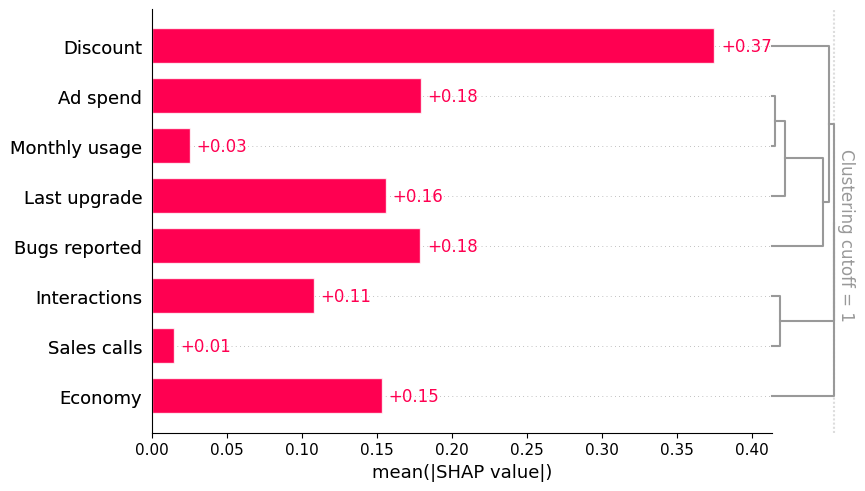

In [13]:
# Interactions and sales calls are very redundant with one another.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

[17:38:42] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


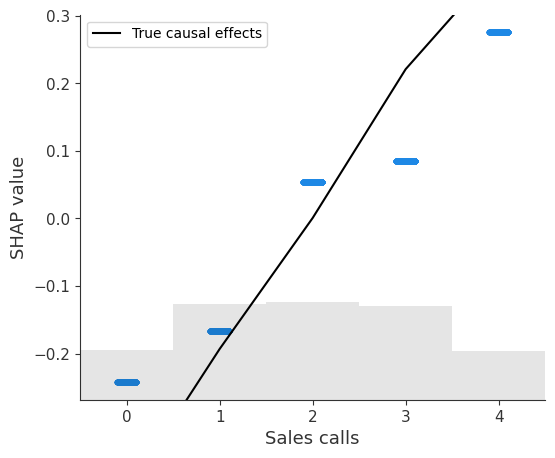

In [14]:
# Fit, explain, and plot a univariate model with just Sales calls
# Note how this model does not have to split of credit between Sales calls and
# Interactions, so we get a better agreement with the true causal effect.
sales_calls_model = fit_xgboost(X[["Sales calls"]], y)
sales_calls_shap_values = shap.Explainer(sales_calls_model)(X[["Sales calls"]])
shap.plots.scatter(
    sales_calls_shap_values,
    overlay={
        "True causal effects": marginal_effects(generator, 10000, ["Sales calls"])
    },
)

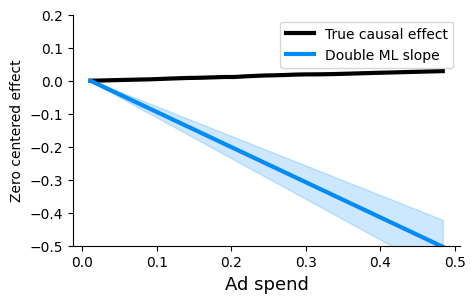

In [15]:
# estimate the causal effect of Ad spend controlling for all the other features
causal_feature = "Discount"
control_features = [
    "Sales calls",
    "Interactions",
    "Economy",
    "Last upgrade",
    "Monthly usage",
    "Ad spend",
    "Bugs reported",
]
effect = double_ml(y, X[causal_feature], X.loc[:, control_features])

# plot the estimated slope against the true effect
xs, true_ys = marginal_effects(generator, 10000, X[[causal_feature]], logit=False)[0]
plot_effect(effect, xs, true_ys, ylim=(-0.5, 0.2))